In [27]:
import numpy
from matplotlib import pyplot
import matplotlib
import os

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [28]:
basedir = "markov_data"

In [29]:
data = {}

for file in os.listdir(basedir):
    if file.endswith(".npz"):
        arr = numpy.load(os.path.join(basedir, file))
        L = arr["L"][()]
        if L not in data:
            data[L] = []
        data[L].append({key: arr[key] for key in arr._files})

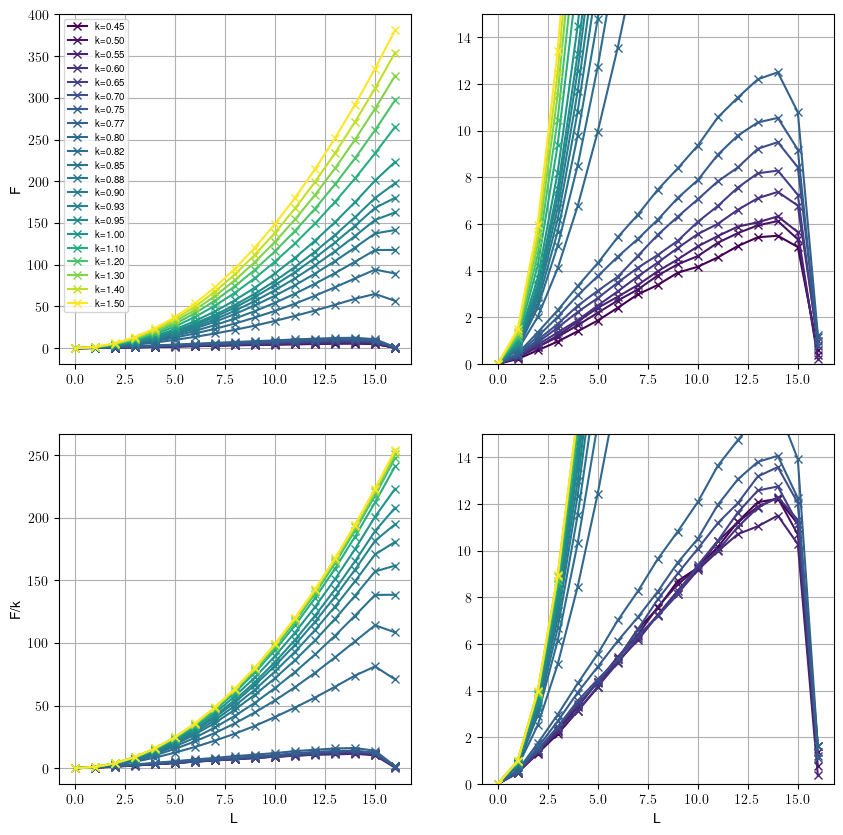

In [30]:
L = 16

kmin = min(d["k"][()] for d in data[L])
kmax = max(d["k"][()] for d in data[L])
norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, axs = pyplot.subplots(2,2, figsize=(10,10))

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.2f}", c=cmap(k))
axs[0,0].grid()
axs[0,0].legend(fontsize=7)
axs[0,0].set_ylabel("F")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,0].grid()
axs[1,0].set_xlabel("L")
axs[1,0].set_ylabel("F/k")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[0,1].grid()
axs[0,1].set_ylim([0,15])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,1].grid()
axs[1,1].set_ylim([0,15])
axs[1,1].set_xlabel("L")

pyplot.savefig("free_energy_flows.png")
pyplot.show()

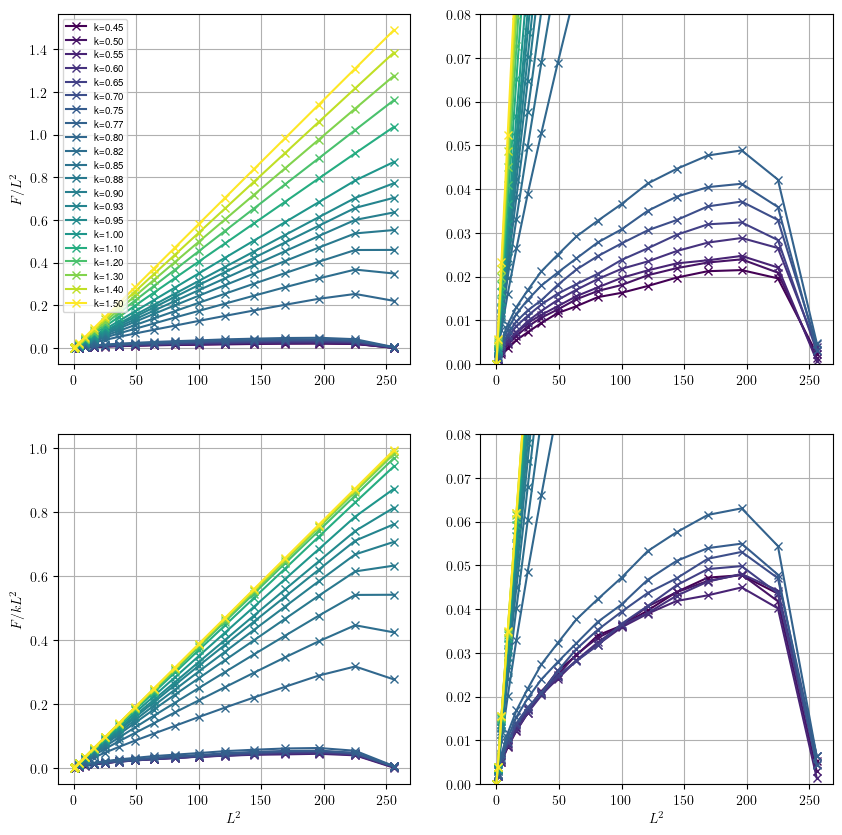

In [31]:
L = 16

kmin = min(d["k"][()] for d in data[L])
kmax = max(d["k"][()] for d in data[L])
norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, axs = pyplot.subplots(2,2, figsize=(10,10))
xs = numpy.arange(L+1)**2
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot(xs, [d["free_energy"][i*i]/(L**2) for i in range(L+1)], "x-", label=f"k={k:.2f}", c=cmap(k))
axs[0,0].grid()
axs[0,0].legend(fontsize=7)
axs[0,0].set_ylabel("$F/L^2$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot(xs, [d["free_energy"][i*i] / (k * L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,0].grid()
axs[1,0].set_xlabel("$L^2$")
axs[1,0].set_ylabel("$F/k L^2$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot(xs, [d["free_energy"][i*i]/(L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[0,1].grid()
axs[0,1].set_ylim([0,0.08])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot(xs, [d["free_energy"][i*i] / (k * L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,1].grid()
axs[1,1].set_ylim([0,0.08])
axs[1,1].set_xlabel("$L^2$")

pyplot.savefig("free_energy_flows_sqr.png")
pyplot.show()

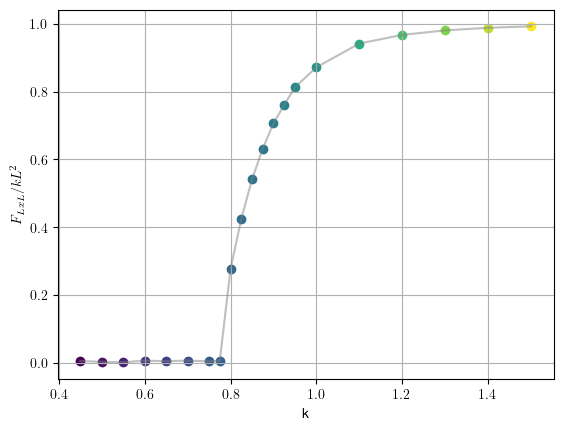

In [32]:
all_dat = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = d["free_energy"][L*L]/(k*L*L)
    all_dat.append((k,lf))
pyplot.plot(*zip(*all_dat), c='gray', alpha=0.5)

for k, lf in all_dat:
    pyplot.scatter([k], [lf], c=[cmap(k)])

pyplot.ylabel(r"$F_{LxL} / k L^2$")
pyplot.xlabel(r"k") 
pyplot.grid()
pyplot.savefig("cost_for_plane.png")
pyplot.show()

# Derivative stuff

In [33]:
L = 16
all_dat = []

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = [d["free_energy"][i*i] for i in range(L + 1)]
    gradlf = numpy.gradient(lf)
    grad2lf = numpy.gradient(gradlf)
    all_dat.append((k,lf, gradlf, grad2lf))

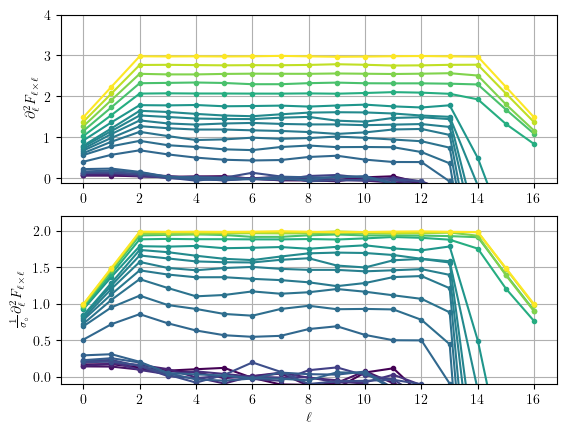

In [59]:
fig, axs = pyplot.subplots(2)

for (k, _, _, grad2lf) in all_dat:
    axs[0].plot(grad2lf, '.-', c=cmap(k))
axs[0].grid()
axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, _, grad2lf) in all_dat:
    axs[1].plot(grad2lf/k, '.-', c=cmap(k))
axs[1].grid()
axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.savefig("second_derive_across_ell.png")
pyplot.show()

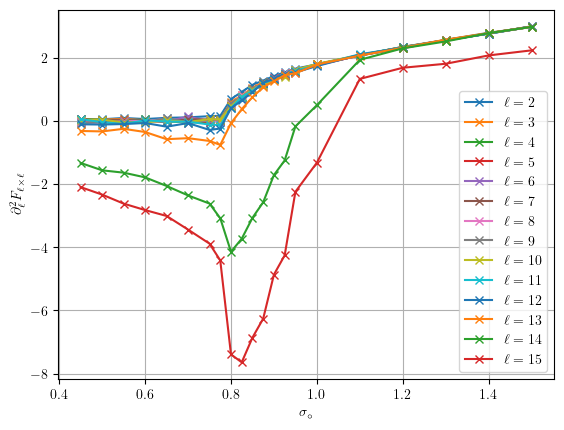

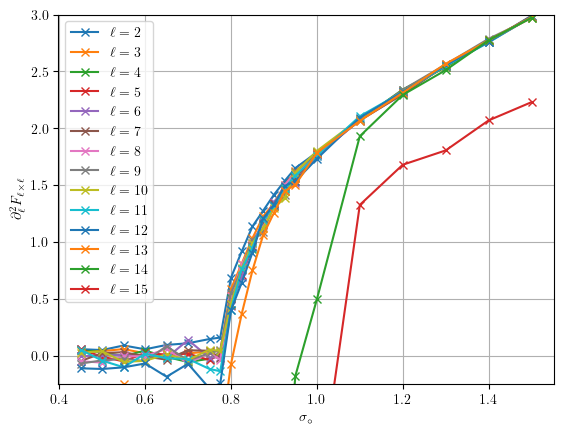

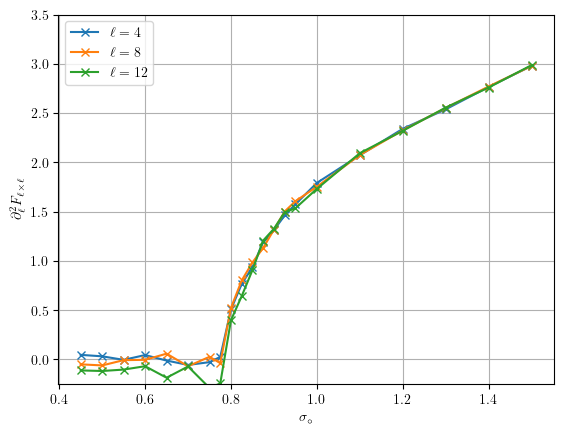

In [57]:
for i in range(2,16):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.show()

for i in range(2,16):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,3))
pyplot.show()


for i in [4,8,12]:
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,3.5))
pyplot.savefig("second_deriv.png")
pyplot.show()